<a href="https://colab.research.google.com/github/jeenraju/Projects/blob/main/Project_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#Convert MNIST image files into a tensor of 4 dimensions(no;of images, height, width, channels)
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.29MB/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.37MB/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [6]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
pwd

'/content'

In [10]:
ls

sample_data/


In [11]:
cd ../

/


In [12]:
pwd

'/'

In [13]:
 ls

bin@                        datalab/  lib32@   NGC-DL-CONTAINER-LICENSE  root/  tmp/
boot/                       dev/      lib64@   opt/                      run/   tools/
cnn_data/                   etc/      libx32@  proc/                     sbin@  usr/
content/                    home/     media/   python-apt/               srv/   var/
cuda-keyring_1.0-1_all.deb  lib@      mnt/     python-apt.tar.xz*        sys/


In [14]:
cd cnn_data/

/cnn_data


In [15]:
ls

MNIST/


In [16]:
cd ../

/


In [17]:
ls

bin@                        datalab/  lib32@   NGC-DL-CONTAINER-LICENSE  root/  tmp/
boot/                       dev/      lib64@   opt/                      run/   tools/
cnn_data/                   etc/      libx32@  proc/                     sbin@  usr/
content/                    home/     media/   python-apt/               srv/   var/
cuda-keyring_1.0-1_all.deb  lib@      mnt/     python-apt.tar.xz*        sys/


In [18]:
cd content/

/content


In [19]:
pwd

'/content'

In [20]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [37]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16*5*5) # -1 because we can vary the batch size

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [38]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
import time
start_time = time.time()
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1] #add up the number of predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False = 0, sum those up
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'epoch: {i} batch: {b}  loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes!')


epoch: 0 batch: 600  loss: 0.5077105760574341
epoch: 0 batch: 1200  loss: 0.05362176150083542
epoch: 0 batch: 1800  loss: 0.018044013530015945
epoch: 0 batch: 2400  loss: 0.06764677911996841
epoch: 0 batch: 3000  loss: 0.2961964011192322
epoch: 0 batch: 3600  loss: 0.056099336594343185
epoch: 0 batch: 4200  loss: 0.014083673246204853
epoch: 0 batch: 4800  loss: 0.009338987059891224
epoch: 0 batch: 5400  loss: 0.012702901847660542
epoch: 0 batch: 6000  loss: 0.19255280494689941
epoch: 1 batch: 600  loss: 0.054840367287397385
epoch: 1 batch: 1200  loss: 0.3729242980480194
epoch: 1 batch: 1800  loss: 0.014574679546058178
epoch: 1 batch: 2400  loss: 0.0012738369405269623
epoch: 1 batch: 3000  loss: 0.0035813748836517334
epoch: 1 batch: 3600  loss: 0.0034778467379510403
epoch: 1 batch: 4200  loss: 0.07481569051742554
epoch: 1 batch: 4800  loss: 0.0004235203959979117
epoch: 1 batch: 5400  loss: 0.018281590193510056
epoch: 1 batch: 6000  loss: 0.1088128313422203
epoch: 2 batch: 600  loss: 0.0

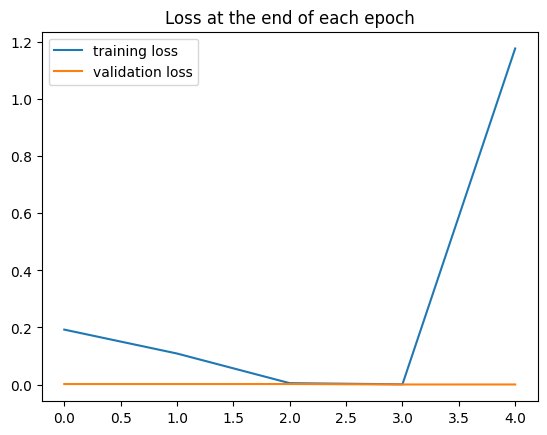

In [44]:
train_losses = [t.item() for t in train_losses]
# test_losses = [t.item() for t in test_losses]
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

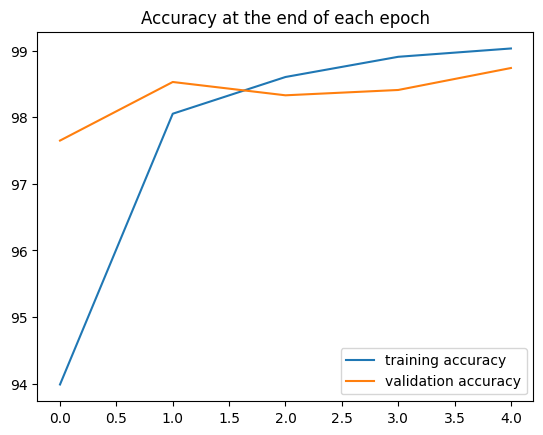

In [45]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [46]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [50]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test accuracy: {correct.item()/len(test_data)}')

Test accuracy: 0.9874


In [22]:
#this is just an example
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [24]:
#grab 1 MNIST image
for i, (X_train, y_train) in enumerate(train_data):
  break

In [25]:
X_train.shape

torch.Size([1, 28, 28])

In [26]:
x = X_train.view(1,1,28,28)

In [27]:
x = F.relu(conv1(x))

In [30]:
# 1-> single image, 6-> filters we asked for, 26x26 -> size after conv since padding =0
x.shape

torch.Size([1, 6, 26, 26])

In [31]:
x = F.max_pool2d(x, 2, 2) # kernel =2 and stride =2

In [32]:
x.shape

torch.Size([1, 6, 13, 13])

In [33]:
x = F.relu(conv2(x))

In [34]:
x.shape

torch.Size([1, 16, 11, 11])

In [35]:
x = F.max_pool2d(x, 2, 2)

In [36]:
x.shape

torch.Size([1, 16, 5, 5])